## Mini project from UBC MDS DSCI 571 Lab 4
The goal of this project is to estimate abalone age with various characteristics. The data can be found [here](https://archive.ics.uci.edu/ml/datasets/abalone). This data is named `abalone_age.csv` in your repository and consists of 8 features and 1 response variable:

- Sex (M, F, I (infant))
- Length (mm)
- Diameter (mm)
- Height (mm)
- Whole weight (grams)
- Shucked weight (grams)
- Viscera weight (grams)
- Shell weight (grams)
- Rings (+1.5 to the number of rings gives the age of the abalone in years)

### Import Packages

In [ ]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

### Simple EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole weight      4177 non-null float64
Shucked weight    4177 non-null float64
Viscera weight    4177 non-null float64
Shell weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


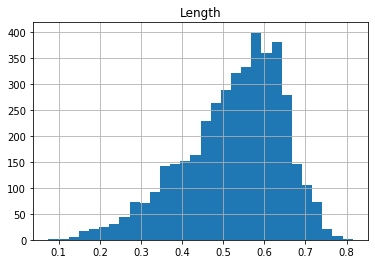

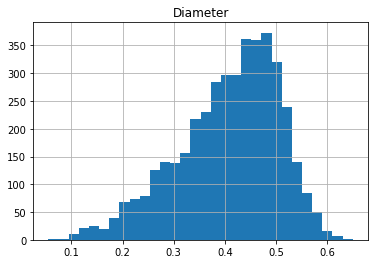

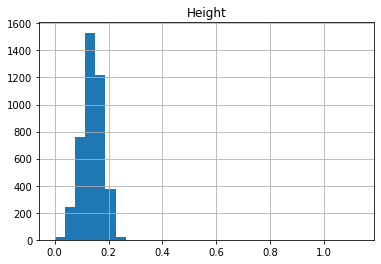

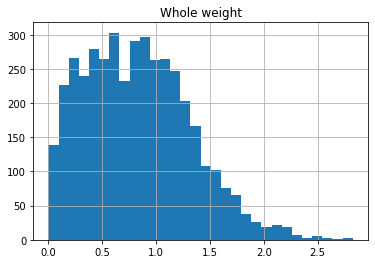

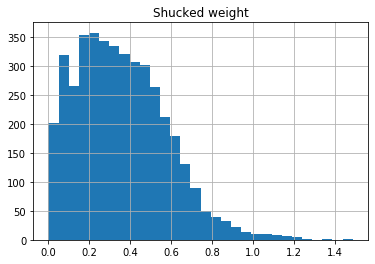

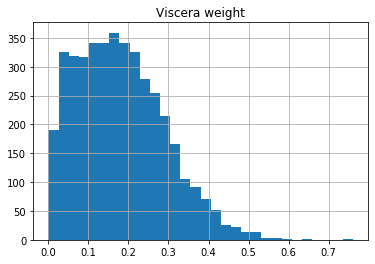

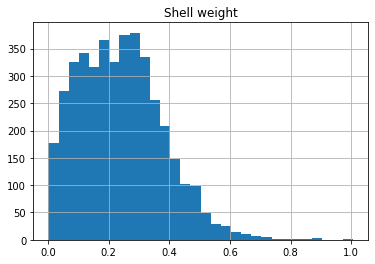

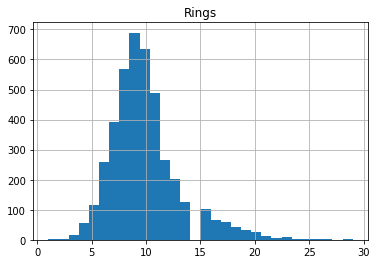

In [335]:
abalone_df = pd.read_csv("abalone_age.csv")

for column in abalone_df.columns[1:]:
    abalone_df.hist(str(column), bins = 30)

abalone_df.info()
abalone_df.describe()

> There are no null values and the distribution of most features are right skewed other than length and diameter which are left skewed. There doesn't appear to be any major outliers. Although, height of 0 doesn't seem to make much sense. 

In [336]:
abalone_df['age'] = abalone_df['Rings'] + 1.5

In [337]:
features = abalone_df.drop(columns = ['Rings', 'age'])
target = abalone_df['age']

In [338]:
# scale numerical features and ohe categorical features

numeric_features = ['Length', 'Diameter', 'Height', 'Whole weight', 
                    'Shucked weight', 'Viscera weight', 'Shell weight']
categorical_features = ['Sex']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(drop="first"), categorical_features)])

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

X_train = pd.DataFrame(preprocessor.fit_transform(X_train),
                       index=X_train.index,
                       columns=(numeric_features +
                                list(preprocessor.named_transformers_['ohe']
                                     .get_feature_names(categorical_features))))
X_test = pd.DataFrame(preprocessor.transform(X_test),
                      index=X_test.index,
                      columns=X_train.columns)

In [339]:
# Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train);

In [340]:
# Support vector regressor

tuned_parameters = {'kernel': ['linear', 'poly', 'rbf'],
                    'gamma': ['scale', 'auto'],
                    'C': [1, 3, 5]}

svr = GridSearchCV(SVR(), param_grid = tuned_parameters, cv = 5)
svr.fit(X_train, y_train);

print('The best choice of parameter:', svr.best_params_)

/Users/bradentam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best choice of parameter: {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}


In [341]:
# k neighbours regressor

tuned_parameters = {'n_neighbors': range(1, 20)}

knr = GridSearchCV(KNeighborsRegressor(), param_grid = tuned_parameters, cv = 5)
knr.fit(X_train, y_train);

print('The best choice of parameter:', knr.best_params_)

The best choice of parameter: {'n_neighbors': 16}


In [342]:
# random forest regressor

tuned_parameters = {'n_estimators': range(90, 120, 10),
                    'max_features': range(1, 9, 2)}

rfr = GridSearchCV(RandomForestRegressor(), param_grid = tuned_parameters, cv = 5)
rfr.fit(X_train, y_train);

print('The best choice of parameter:', rfr.best_params_)

The best choice of parameter: {'max_features': 3, 'n_estimators': 90}


In [348]:
print("RMSE of lin_reg of test set:", np.sqrt(mean_squared_error(y_test, lin_reg.predict(X_test))))
print("RMSE of knr of test set:", np.sqrt(mean_squared_error(y_test, knr.predict(X_test))))
print("RMSE of svr of test set:", np.sqrt(mean_squared_error(y_test, svr.predict(X_test))))
print("RMSE of rfr of test set:", np.sqrt(mean_squared_error(y_test, rfr.predict(X_test))))

RMSE of lin_reg of test set: 2.194847069345932
RMSE of knr of test set: 2.1678586771326076
RMSE of svr of test set: 2.0737479524269373
RMSE of rfr of test set: 2.116766746487386


In [349]:
results = pd.DataFrame({'observed': y_test,
                        'lin_reg': lin_reg.predict(X_test), 
                        'knr': knr.predict(X_test),
                        'svr': svr.predict(X_test), 
                        'rfr': rfr.predict(X_test)})

results = results.melt(id_vars = ['observed'], value_vars = ['lin_reg', 'knr', 'svr', 'rfr'])
results = results.rename(columns = {'variable': 'model', 
                                    'value': 'predicted'})
results_avg = results.groupby(['observed', 'model']).mean()
results_avg = results_avg.reset_index()

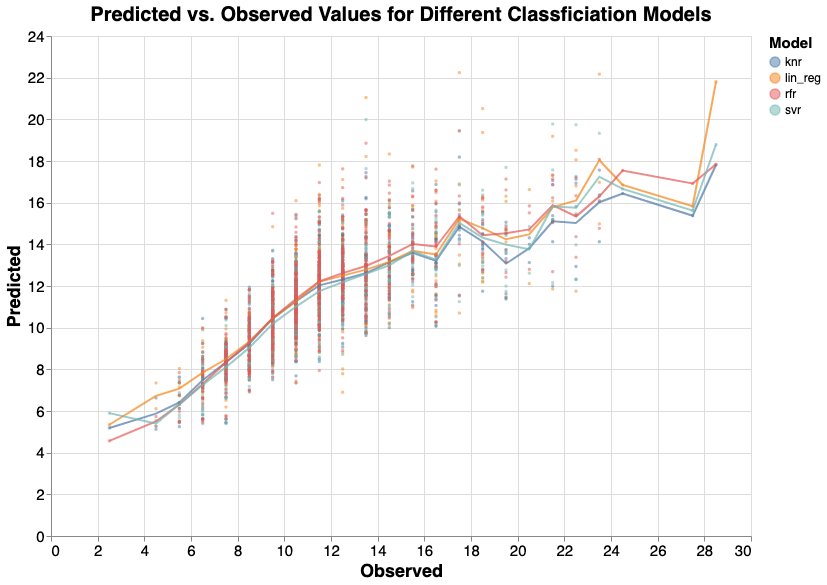

In [355]:
c1 = alt.Chart(results).mark_circle(size = 10, opacity = 0.5).encode(
    alt.X('observed:Q', title = 'Observed'),
    alt.Y('predicted:Q', title = 'Predicted'),
    alt.Color('model', legend = alt.Legend(title = 'Model', titleFontSize = 15, labelFontSize = 12))
)

c2 = alt.Chart(results_avg).mark_line(size = 2, opacity = 0.7).encode(
    alt.X('observed:Q'),
    alt.Y('predicted:Q'),
    alt.Color('model', legend = alt.Legend(title = 'Model', titleFontSize = 15, labelFontSize = 12))
)

(c1 + c2
).properties(height = 500, width = 700, 
                     title = "Predicted vs. Observed Values for Different Classficiation Models"
).configure_axis(
    labelFontSize=15, titleFontSize=18
).configure_title(
    fontSize=20
)


> All models perform very similarly with all having RMSE values of around 2. The SVR model performs slightly better than the rest of the models with a RMSE value of 2.07 vs 2.11, 2.18, and 2.19. This difference is not significant enough to make any claims about why the model perform slightly differently.

> To improve the model performance, we can implement an ensemble of many different models. In addition, adjustments during the preprocessing stage can be make such as different methods for scaling and encoding categorical variables. 